#### Notebook Summary
This notebook contains experimentation to determine the best performing model types and the best performing resampling methods. It also explores the multicollinearity identified and the impact of removing these highly correlated features.

In [1]:
import pandas as pd
import numpy as np
import sklearn.metrics as metrics

from sklearn.compose import ColumnTransformer
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, RandomOverSampler, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.kernel_approximation import RBFSampler

In [2]:
df = pd.read_csv('../../data/yelp_training/yelp_zip_processed_features.csv', sep='\t')
df.head()

,user_id,business_id,rating,num_word,num_noun,num_verb,num_adj,num_adv,num_personal_pronoun,avg_word_len,...,user_content_similarity,positive_reviews,negative_reviews,positive_review_ratio,negative_review_ratio,avg_business_sentiment,avg_business_rating,total_business_reviews,lemma,label
0,5044,0,1.0,35,9,2,5,2,1,5.000000,...,0.000000e+00,0.0,1.0,0.00,1.0,0.141963,3.613636,88,drink bad hot chocolate water latte burn taste...,-1
1,5045,0,1.0,241,54,31,16,15,7,5.561905,...,0.000000e+00,0.0,1.0,0.00,1.0,0.141963,3.613636,88,bad experience casual coffee light fare place ...,-1
2,5046,0,3.0,49,11,3,9,2,1,5.130435,...,4.074681e-02,1.0,0.0,0.25,0.0,0.141963,3.613636,88,locate site old spruce st video mild cofee goo...,-1
3,5047,0,5.0,216,56,33,19,14,5,5.941176,...,4.440892e-16,1.0,0.0,1.00,0.0,0.141963,3.613636,88,enjoy coffee breakfast twice toast recent visi...,-1
4,5048,0,5.0,146,31,23,15,9,8,5.507246,...,0.000000e+00,1.0,0.0,1.00,0.0,0.141963,3.613636,88,love toast food choice fantastic love serve br...,-1


In [43]:
numeric_feature_columns = ['rating',
                           #'num_word',
                           #'num_noun',
                           #'num_verb',
                           #'num_adj',
                           #'num_adv',
                           #'num_personal_pronoun',
                           #'avg_word_len',
                           'lexical_diversity',
                           'sentiment',
                           #'typo_ratio',
                           'emotiveness_ratio',
                           #'num_positive_words',
                           'num_negative_words',
                           'num_clauses',
                           'previous_user_reviews',
                           'avg_user_sentiment',
                           #'avg_user_rating',
                           'total_user_reviews',
                           'user_content_similarity',
                           'positive_reviews',
                           'negative_reviews',
                           #'positive_review_ratio',
                           'negative_review_ratio',
                           'avg_business_sentiment',
                           'avg_business_rating',
                           'total_business_reviews']
text_feature_columns = ['lemma']
id_columns = ['user_id', 'business_id']

TODO: Visualization to compare the top two models that we select


In [ ]:
['rating', 'lexical_diversity', 'sentiment', 'emotiveness_ratio',
 'num_positive_words', 'num_negative_words', 'num_clauses',
 'previous_user_reviews', 'avg_user_sentiment', 'avg_user_rating',
 'total_user_reviews', 'user_content_similarity', 'positive_reviews',
 'negative_reviews', 'negative_review_ratio',
 'avg_business_sentiment', 'avg_business_rating', 'total_business_reviews']

In [4]:
null_lemma = df['lemma'].isna()
filtered_df = df[~null_lemma]
filtered_df.shape

(608463, 31)

In [10]:
filtered_df['num_word']

,user_id,business_id,rating,num_word,num_noun,num_verb,num_adj,num_adv,num_personal_pronoun,avg_word_len,...,user_content_similarity,positive_reviews,negative_reviews,positive_review_ratio,negative_review_ratio,avg_business_sentiment,avg_business_rating,total_business_reviews,lemma,label
0,5044,0,1.0,35,9,2,5,2,1,5.000000,...,0.000000e+00,0.0,1.0,0.00,1.0,0.141963,3.613636,88,drink bad hot chocolate water latte burn taste...,-1
1,5045,0,1.0,241,54,31,16,15,7,5.561905,...,0.000000e+00,0.0,1.0,0.00,1.0,0.141963,3.613636,88,bad experience casual coffee light fare place ...,-1
2,5046,0,3.0,49,11,3,9,2,1,5.130435,...,4.074681e-02,1.0,0.0,0.25,0.0,0.141963,3.613636,88,locate site old spruce st video mild cofee goo...,-1
3,5047,0,5.0,216,56,33,19,14,5,5.941176,...,4.440892e-16,1.0,0.0,1.00,0.0,0.141963,3.613636,88,enjoy coffee breakfast twice toast recent visi...,-1
4,5048,0,5.0,146,31,23,15,9,8,5.507246,...,0.000000e+00,1.0,0.0,1.00,0.0,0.141963,3.613636,88,love toast food choice fantastic love serve br...,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608593,259494,4877,1.0,84,15,13,6,3,9,5.162162,...,2.220446e-16,0.0,1.0,0.00,1.0,0.162162,1.000000,1,new restaurant newark international airport ga...,1
608594,260401,4176,5.0,28,7,4,4,2,1,5.400000,...,2.220446e-16,1.0,0.0,1.00,0.0,0.204762,5.000000,2,appreciate good sub roll slack bestreet good s...,1
608595,260402,4176,5.0,66,14,8,9,2,3,5.514286,...,2.220446e-16,1.0,0.0,1.00,0.0,0.204762,5.000000,2,good philly hoagie cheesesteak delaware river ...,1
608596,265185,2984,5.0,47,14,6,8,4,3,6.392857,...,0.000000e+00,1.0,0.0,1.00,0.0,0.160714,5.000000,2,food amazing authentic haitian cuisine absolut...,1


<AxesSubplot:>

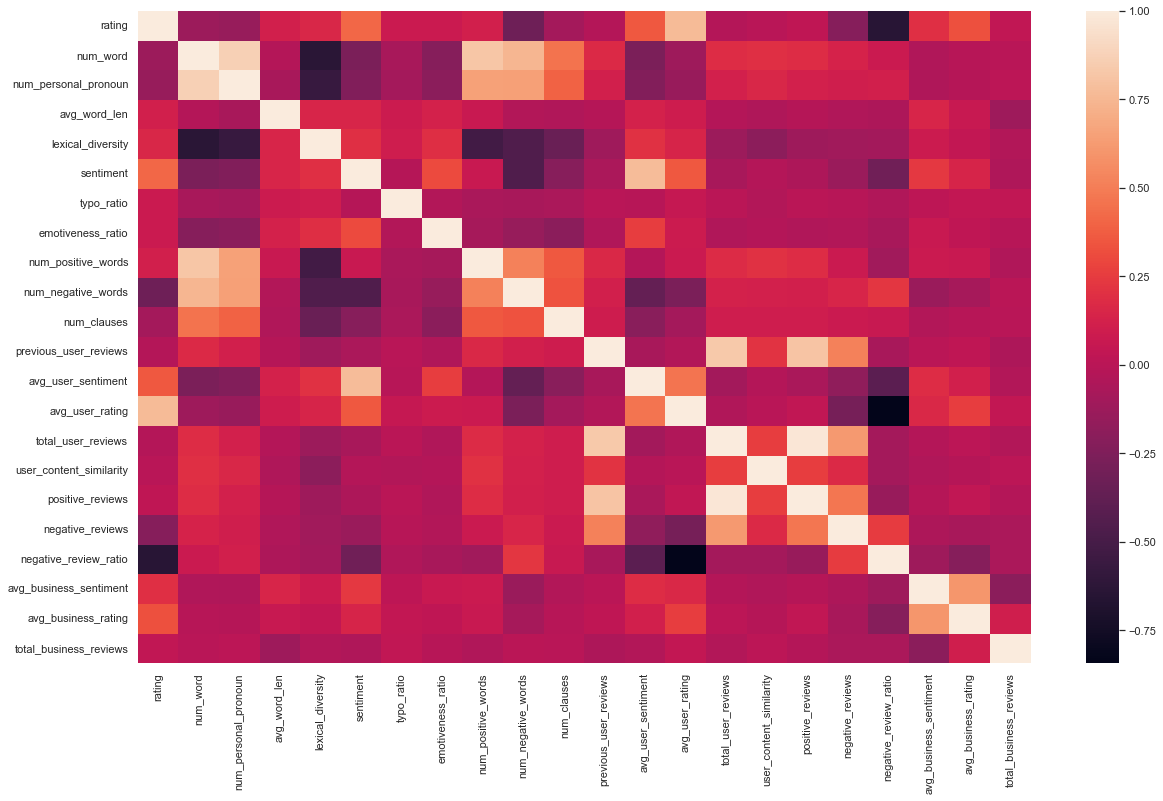

In [26]:
import seaborn as sns
sns.set(rc={"figure.figsize":(20, 12)})
sns.heatmap(filtered_df[numeric_feature_columns].corr())

In [15]:
filtered_df.iloc[5]

user_id                                                                 5049
business_id                                                                0
rating                                                                   5.0
num_word                                                                  71
num_noun                                                                  19
num_verb                                                                   7
num_adj                                                                   11
num_adv                                                                    2
num_personal_pronoun                                                       4
avg_word_len                                                        5.918919
lexical_diversity                                                   0.918919
sentiment                                                           0.216216
typo_ratio                                                          0.070423

For reference, the baseline LinearSVC model had the following performance:  

|             | precision  |  recall | f1-score  |  support  |
|-------------|------------|---------|-----------|-----------|
|          -1 |      0.28  |    0.63 |     0.38  |   24077   |
|           1 |      0.93  |    0.75 |     0.83  |  158462   |
|    accuracy |            |         |     0.73  |  182539   |
|   macro avg |      0.60  |    0.69 |     0.61  |  182539   |
|weighted avg |      0.84  |    0.73 |     0.77  |  182539   |

Confusion matrix:  
[[ 15148,   8929],  
[ 39627, 118835]]

In [12]:
X_train, X_test, y_train, y_test = train_test_split(filtered_df[numeric_feature_columns + text_feature_columns],
                                                    filtered_df['label'].values,
                                                    test_size=.3,
                                                    random_state=24)
resampler = SMOTE(random_state=24, k_neighbors=3)
summary_pipeline = Pipeline([('scaler', StandardScaler())])
tfidf_pipeline = Pipeline([('vectorizer', TfidfVectorizer(analyzer='word', ngram_range=(1,1)))])
column_processor = ColumnTransformer([('summary', summary_pipeline, numeric_feature_columns),
                                      ('tfidf', tfidf_pipeline, 'lemma')])


# In order to test non-linear RBF kernel, we have to use a kernel approximation because the dataset is too large
rbf_features = RBFSampler(gamma=1, random_state=24)
tfidf_combined_sgd_svm = SGDClassifier(loss='hinge', max_iter=50)

tfidf_combined_sgd_svm_pipe = Pipeline([('preprocessing', column_processor),
                                        ('upsampler', resampler),
                                        ('rbf_transform', rbf_features),
                                        ('svc', tfidf_combined_sgd_svm)])


print(X_train.shape)
print(X_test.shape)
tfidf_combined_sgd_svm_pipe

(425924, 28)
(182539, 28)


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('summary',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['rating', 'num_word',
                                                   'num_noun', 'num_verb',
                                                   'num_adj', 'num_adv',
                                                   'num_personal_pronoun',
                                                   'avg_word_len',
                                                   'lexical_diversity',
                                                   'sentiment', 'typo_ratio',
                                                   'emotiveness_ratio',
                                                   'num_positive_words',
                                                   'num_negative_words',
                                                   'num_clauses',
                                                   'previ...
                                                   'negative_reviews',
                                                   'positive_review_ratio',
                                                   'negative_review_ratio',
                                                   'avg_business_sentiment',
                                                   'avg_business_rating',
                                                   'total_business_reviews']),
                                                 ('tfidf',
                                                  Pipeline(steps=[('vectorizer',
                                                                   TfidfVectorizer())]),
                                                  'lemma')])),
                ('upsampler', SMOTE(k_neighbors=3, random_state=24)),
                ('rbf_transform', RBFSampler(gamma=1, random_state=24)),
                ('svc', SGDClassifier(max_iter=50))])

In [13]:
%%time
tfidf_combined_sgd_svm_pipe.fit(X_train, y_train)

CPU times: total: 4min 59s
Wall time: 5min 1s


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('summary',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['rating', 'num_word',
                                                   'num_noun', 'num_verb',
                                                   'num_adj', 'num_adv',
                                                   'num_personal_pronoun',
                                                   'avg_word_len',
                                                   'lexical_diversity',
                                                   'sentiment', 'typo_ratio',
                                                   'emotiveness_ratio',
                                                   'num_positive_words',
                                                   'num_negative_words',
                                                   'num_clauses',
                                                   'previ...
                                                   'negative_reviews',
                                                   'positive_review_ratio',
                                                   'negative_review_ratio',
                                                   'avg_business_sentiment',
                                                   'avg_business_rating',
                                                   'total_business_reviews']),
                                                 ('tfidf',
                                                  Pipeline(steps=[('vectorizer',
                                                                   TfidfVectorizer())]),
                                                  'lemma')])),
                ('upsampler', SMOTE(k_neighbors=3, random_state=24)),
                ('rbf_transform', RBFSampler(gamma=1, random_state=24)),
                ('svc', SGDClassifier(max_iter=50))])

In [14]:
%%time
tfidf_combined_preds = tfidf_combined_sgd_svm_pipe.predict(X_test)

print(metrics.classification_report(y_test, tfidf_combined_preds))
metrics.confusion_matrix(y_test, tfidf_combined_preds)

              precision    recall  f1-score   support

          -1       0.13      0.52      0.21     24077
           1       0.87      0.48      0.62    158462

    accuracy                           0.49    182539
   macro avg       0.50      0.50      0.42    182539
weighted avg       0.77      0.49      0.57    182539

CPU times: total: 7.94 s
Wall time: 7.98 s


array([[12459, 11618],
       [81771, 76691]], dtype=int64)

In [6]:
## Upscaling using smote, but using class weight to indicate "true" distribution

null_lemma = df['lemma'].isna()
filtered_df = df[~null_lemma]



X_train, X_test, y_train, y_test = train_test_split(filtered_df[numeric_feature_columns + text_feature_columns],
                                                    filtered_df['label'].values,
                                                    test_size=.3,
                                                    random_state=24)
resampler = SMOTE(random_state=24, k_neighbors=3)
summary_pipeline = Pipeline([('scaler', StandardScaler())])
tfidf_pipeline = Pipeline([('vectorizer', TfidfVectorizer(analyzer='word', ngram_range=(1,1)))])
column_processor = ColumnTransformer([('summary', summary_pipeline, numeric_feature_columns),
                                      ('tfidf', tfidf_pipeline, 'lemma')])


# Upscaling to rebalance the dataset, then applying class weight to indicate the true distribution. 
# Not sure that this will be useful, but wanted to try and see
tfidf_combined_svm = LinearSVC(class_weight={1: .85, -1: .15})

tfidf_combined_svm_pipe = Pipeline([('preprocessing', column_processor),
                                    ('upsampler', resampler),
                                    ('svc', tfidf_combined_svm)])


print(X_train.shape)
print(X_test.shape)
tfidf_combined_svm_pipe

(425924, 28)
(182539, 28)


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('summary',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['rating', 'num_word',
                                                   'num_noun', 'num_verb',
                                                   'num_adj', 'num_adv',
                                                   'num_personal_pronoun',
                                                   'avg_word_len',
                                                   'lexical_diversity',
                                                   'sentiment', 'typo_ratio',
                                                   'emotiveness_ratio',
                                                   'num_positive_words',
                                                   'num_negative_words',
                                                   'num_clauses',
                                                   'previ...
                                                   'user_content_similarity',
                                                   'positive_reviews',
                                                   'negative_reviews',
                                                   'positive_review_ratio',
                                                   'negative_review_ratio',
                                                   'avg_business_sentiment',
                                                   'avg_business_rating',
                                                   'total_business_reviews']),
                                                 ('tfidf',
                                                  Pipeline(steps=[('vectorizer',
                                                                   TfidfVectorizer())]),
                                                  'lemma')])),
                ('upsampler', SMOTE(k_neighbors=3, random_state=24)),
                ('svc', LinearSVC(class_weight={-1: 0.15, 1: 0.85}))])

In [8]:
%%time
tfidf_combined_svm_pipe.fit(X_train, y_train)

CPU times: total: 11min
Wall time: 11min 4s


E:\Data_Science_Studies\GTech\.venv\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('summary',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['rating', 'num_word',
                                                   'num_noun', 'num_verb',
                                                   'num_adj', 'num_adv',
                                                   'num_personal_pronoun',
                                                   'avg_word_len',
                                                   'lexical_diversity',
                                                   'sentiment', 'typo_ratio',
                                                   'emotiveness_ratio',
                                                   'num_positive_words',
                                                   'num_negative_words',
                                                   'num_clauses',
                                                   'previ...
                                                   'user_content_similarity',
                                                   'positive_reviews',
                                                   'negative_reviews',
                                                   'positive_review_ratio',
                                                   'negative_review_ratio',
                                                   'avg_business_sentiment',
                                                   'avg_business_rating',
                                                   'total_business_reviews']),
                                                 ('tfidf',
                                                  Pipeline(steps=[('vectorizer',
                                                                   TfidfVectorizer())]),
                                                  'lemma')])),
                ('upsampler', SMOTE(k_neighbors=3, random_state=24)),
                ('svc', LinearSVC(class_weight={-1: 0.15, 1: 0.85}))])

In [9]:
%%time
tfidf_combined_preds = tfidf_combined_svm_pipe.predict(X_test)

print(metrics.classification_report(y_test, tfidf_combined_preds))
metrics.confusion_matrix(y_test, tfidf_combined_preds)

              precision    recall  f1-score   support

          -1       0.47      0.13      0.20     24077
           1       0.88      0.98      0.93    158462

    accuracy                           0.87    182539
   macro avg       0.68      0.55      0.56    182539
weighted avg       0.83      0.87      0.83    182539

CPU times: total: 7.42 s
Wall time: 7.43 s


array([[  3038,  21039],
       [  3385, 155077]], dtype=int64)

In [10]:
## Using class weight to indicate "true" distribution isntead of upscaling with SMOTE

null_lemma = df['lemma'].isna()
filtered_df = df[~null_lemma]



X_train, X_test, y_train, y_test = train_test_split(filtered_df[numeric_feature_columns + text_feature_columns],
                                                    filtered_df['label'].values,
                                                    test_size=.3,
                                                    random_state=24)
resampler = SMOTE(random_state=24, k_neighbors=3)
summary_pipeline = Pipeline([('scaler', StandardScaler())])
tfidf_pipeline = Pipeline([('vectorizer', TfidfVectorizer(analyzer='word', ngram_range=(1,1)))])
column_processor = ColumnTransformer([('summary', summary_pipeline, numeric_feature_columns),
                                      ('tfidf', tfidf_pipeline, 'lemma')])


# Upscaling to rebalance the dataset, then applying class weight to indicate the true distribution. 
# Not sure that this will be useful, but wanted to try and see
tfidf_combined_svm = LinearSVC(class_weight='balanced')

tfidf_combined_svm_pipe = Pipeline([('preprocessing', column_processor),
                                    #('upsampler', resampler),
                                    ('svc', tfidf_combined_svm)])


print(X_train.shape)
print(X_test.shape)
tfidf_combined_svm_pipe

(425924, 28)
(182539, 28)


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('summary',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['rating', 'num_word',
                                                   'num_noun', 'num_verb',
                                                   'num_adj', 'num_adv',
                                                   'num_personal_pronoun',
                                                   'avg_word_len',
                                                   'lexical_diversity',
                                                   'sentiment', 'typo_ratio',
                                                   'emotiveness_ratio',
                                                   'num_positive_words',
                                                   'num_negative_words',
                                                   'num_clauses',
                                                   'previ...
                                                   'avg_user_sentiment',
                                                   'avg_user_rating',
                                                   'total_user_reviews',
                                                   'user_content_similarity',
                                                   'positive_reviews',
                                                   'negative_reviews',
                                                   'positive_review_ratio',
                                                   'negative_review_ratio',
                                                   'avg_business_sentiment',
                                                   'avg_business_rating',
                                                   'total_business_reviews']),
                                                 ('tfidf',
                                                  Pipeline(steps=[('vectorizer',
                                                                   TfidfVectorizer())]),
                                                  'lemma')])),
                ('svc', LinearSVC(class_weight='balanced'))])

In [11]:
%%time
tfidf_combined_svm_pipe.fit(X_train, y_train)

CPU times: total: 3min 40s
Wall time: 3min 42s


E:\Data_Science_Studies\GTech\.venv\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('summary',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['rating', 'num_word',
                                                   'num_noun', 'num_verb',
                                                   'num_adj', 'num_adv',
                                                   'num_personal_pronoun',
                                                   'avg_word_len',
                                                   'lexical_diversity',
                                                   'sentiment', 'typo_ratio',
                                                   'emotiveness_ratio',
                                                   'num_positive_words',
                                                   'num_negative_words',
                                                   'num_clauses',
                                                   'previ...
                                                   'avg_user_sentiment',
                                                   'avg_user_rating',
                                                   'total_user_reviews',
                                                   'user_content_similarity',
                                                   'positive_reviews',
                                                   'negative_reviews',
                                                   'positive_review_ratio',
                                                   'negative_review_ratio',
                                                   'avg_business_sentiment',
                                                   'avg_business_rating',
                                                   'total_business_reviews']),
                                                 ('tfidf',
                                                  Pipeline(steps=[('vectorizer',
                                                                   TfidfVectorizer())]),
                                                  'lemma')])),
                ('svc', LinearSVC(class_weight='balanced'))])

In [12]:
%%time
tfidf_combined_preds = tfidf_combined_svm_pipe.predict(X_test)

print(metrics.classification_report(y_test, tfidf_combined_preds))
metrics.confusion_matrix(y_test, tfidf_combined_preds)

              precision    recall  f1-score   support

          -1       0.28      0.67      0.39     24077
           1       0.94      0.73      0.82    158462

    accuracy                           0.73    182539
   macro avg       0.61      0.70      0.61    182539
weighted avg       0.85      0.73      0.77    182539

CPU times: total: 7.3 s
Wall time: 7.37 s


array([[ 16044,   8033],
       [ 42099, 116363]], dtype=int64)

In [24]:
sorted(enumerate(tfidf_combined_svm_pipe[1].coef_[0]), key=lambda x: x[1], reverse=True)

[(92409, 2.627556198434241),
 (67606, 2.6094714894509314),
 (42798, 2.5080238708140614),
 (4051, 2.500546546932475),
 (94659, 2.498612653774251),
 (112396, 2.48266868877021),
 (79390, 2.4579075747587193),
 (89239, 2.4275393520684494),
 (109684, 2.422870388893927),
 (6944, 2.4077785440137536),
 (51389, 2.373223211427083),
 (97322, 2.363337981193747),
 (51992, 2.3520664288014226),
 (94044, 2.3357493080041536),
 (18694, 2.3355614396058018),
 (19954, 2.309048153032535),
 (122666, 2.2990333140910475),
 (99068, 2.2912429946512627),
 (55605, 2.2718244672079946),
 (122580, 2.2714012755540987),
 (94236, 2.262242391096654),
 (33386, 2.260347130226409),
 (42272, 2.2514655917117943),
 (54501, 2.23658944995586),
 (123462, 2.2238934112124578),
 (40758, 2.2134550852948034),
 (119651, 2.209711644797222),
 (33807, 2.205407415162011),
 (87895, 2.1962844463589235),
 (64896, 2.1953064472187203),
 (110966, 2.1783595570489567),
 (56069, 2.176546619609311),
 (15973, 2.173712472736129),
 (30046, 2.17039192567

In [25]:
## Using class weight to indicate "true" distribution isntead of upscaling with SMOTE

null_lemma = df['lemma'].isna()
filtered_df = df[~null_lemma]



X_train, X_test, y_train, y_test = train_test_split(filtered_df[numeric_feature_columns# + text_feature_columns
                                                               ],
                                                    filtered_df['label'].values,
                                                    test_size=.3,
                                                    random_state=24)
resampler = SMOTE(random_state=24, k_neighbors=3)
summary_pipeline = Pipeline([('scaler', StandardScaler())])
#tfidf_pipeline = Pipeline([('vectorizer', TfidfVectorizer(analyzer='word', ngram_range=(1,1)))])
column_processor = ColumnTransformer([('summary', summary_pipeline, numeric_feature_columns),
                                      #('tfidf', tfidf_pipeline, 'lemma')
                                     ])


# Upscaling to rebalance the dataset, then applying class weight to indicate the true distribution. 
# Not sure that this will be useful, but wanted to try and see
summary_svm = LinearSVC(class_weight='balanced')

summary_svm_pipe = Pipeline([('preprocessing', column_processor),
                                    #('upsampler', resampler),
                                    ('svc', summary_svm)])


print(X_train.shape)
print(X_test.shape)
summary_svm_pipe

summary_svm_pipe.fit(X_train, y_train)

summary_preds = summary_svm_pipe.predict(X_test)

print(metrics.classification_report(y_test, summary_preds))
metrics.confusion_matrix(y_test, summary_preds)

(425924, 27)
(182539, 27)


E:\Data_Science_Studies\GTech\.venv\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


              precision    recall  f1-score   support

          -1       0.24      0.79      0.37     24077
           1       0.95      0.63      0.76    158462

    accuracy                           0.65    182539
   macro avg       0.60      0.71      0.56    182539
weighted avg       0.86      0.65      0.71    182539



array([[19135,  4942],
       [59188, 99274]], dtype=int64)

In [27]:
sorted(zip(numeric_feature_columns, summary_svm_pipe[1].coef_[0]), key=lambda x: abs(x[1]), reverse=True)

[('total_user_reviews', 0.581574520479323),
 ('negative_review_ratio', -0.21400118184641637),
 ('negative_reviews', 0.17578590678628106),
 ('user_content_similarity', 0.12012184003150757),
 ('avg_user_sentiment', -0.09259234332328618),
 ('avg_business_rating', 0.08212729589249905),
 ('num_adv', 0.07841899288541827),
 ('avg_user_rating', -0.06808167024161704),
 ('num_noun', 0.06419277868025244),
 ('num_adj', 0.053661350171605685),
 ('num_verb', -0.04446986416152329),
 ('previous_user_reviews', 0.04246629119383659),
 ('num_positive_words', 0.04039575835330244),
 ('avg_business_sentiment', -0.035743663312849505),
 ('total_business_reviews', 0.03362327229669104),
 ('rating', -0.027314719695305613),
 ('num_word', -0.023113922807947693),
 ('positive_reviews', -0.020957651662922225),
 ('num_negative_words', -0.01755745461334746),
 ('emotiveness_ratio', -0.01669291197992224),
 ('num_personal_pronoun', -0.015566657989608738),
 ('typo_ratio', -0.009021651991676299),
 ('num_clauses', 0.0077097864

In [4]:
from sklearn.ensemble import RandomForestClassifier


null_lemma = df['lemma'].isna()
filtered_df = df[~null_lemma]

X_train, X_test, y_train, y_test = train_test_split(filtered_df[numeric_feature_columns + text_feature_columns],
                                                    filtered_df['label'].values,
                                                    test_size=.3,
                                                    random_state=24)
resampler = SMOTE(random_state=24, k_neighbors=3)
summary_pipeline = Pipeline([('scaler', StandardScaler())])
tfidf_pipeline = Pipeline([('vectorizer', TfidfVectorizer(analyzer='word', ngram_range=(1,1)))])
column_processor = ColumnTransformer([('summary', summary_pipeline, numeric_feature_columns),
                                      ('tfidf', tfidf_pipeline, 'lemma')])

rfc = RandomForestClassifier(max_depth=10, max_samples=200000, min_samples_leaf=5)

tfidf_combined_rfc_pipe = Pipeline([('preprocessing', column_processor),
                                    ('upsampler', resampler),
                                    ('rfc', rfc)])


print(X_train.shape)
print(X_test.shape)
tfidf_combined_rfc_pipe

(425924, 28)
(182539, 28)


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('summary',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['rating', 'num_word',
                                                   'num_noun', 'num_verb',
                                                   'num_adj', 'num_adv',
                                                   'num_personal_pronoun',
                                                   'avg_word_len',
                                                   'lexical_diversity',
                                                   'sentiment', 'typo_ratio',
                                                   'emotiveness_ratio',
                                                   'num_positive_words',
                                                   'num_negative_words',
                                                   'num_clauses',
                                                   'previ...
                                                   'positive_reviews',
                                                   'negative_reviews',
                                                   'positive_review_ratio',
                                                   'negative_review_ratio',
                                                   'avg_business_sentiment',
                                                   'avg_business_rating',
                                                   'total_business_reviews']),
                                                 ('tfidf',
                                                  Pipeline(steps=[('vectorizer',
                                                                   TfidfVectorizer())]),
                                                  'lemma')])),
                ('upsampler', SMOTE(k_neighbors=3, random_state=24)),
                ('rfc',
                 RandomForestClassifier(max_depth=10, max_samples=200000,
                                        min_samples_leaf=5))])

In [5]:
%%time
tfidf_combined_rfc_pipe.fit(X_train, y_train)

CPU times: total: 5min 27s
Wall time: 5min 28s


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('summary',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['rating', 'num_word',
                                                   'num_noun', 'num_verb',
                                                   'num_adj', 'num_adv',
                                                   'num_personal_pronoun',
                                                   'avg_word_len',
                                                   'lexical_diversity',
                                                   'sentiment', 'typo_ratio',
                                                   'emotiveness_ratio',
                                                   'num_positive_words',
                                                   'num_negative_words',
                                                   'num_clauses',
                                                   'previ...
                                                   'positive_reviews',
                                                   'negative_reviews',
                                                   'positive_review_ratio',
                                                   'negative_review_ratio',
                                                   'avg_business_sentiment',
                                                   'avg_business_rating',
                                                   'total_business_reviews']),
                                                 ('tfidf',
                                                  Pipeline(steps=[('vectorizer',
                                                                   TfidfVectorizer())]),
                                                  'lemma')])),
                ('upsampler', SMOTE(k_neighbors=3, random_state=24)),
                ('rfc',
                 RandomForestClassifier(max_depth=10, max_samples=200000,
                                        min_samples_leaf=5))])

In [7]:
%%time
rfc_preds = tfidf_combined_rfc_pipe.predict(X_test)

print(metrics.classification_report(y_test, rfc_preds))
metrics.confusion_matrix(y_test, rfc_preds)

              precision    recall  f1-score   support

          -1       0.30      0.68      0.41     24077
           1       0.94      0.76      0.84    158462

    accuracy                           0.75    182539
   macro avg       0.62      0.72      0.63    182539
weighted avg       0.85      0.75      0.78    182539

CPU times: total: 10.9 s
Wall time: 10.9 s


array([[ 16267,   7810],
       [ 38565, 119897]], dtype=int64)

In [12]:
from sklearn.ensemble import RandomForestClassifier

## RandomUndersampler instead of SMOTE upsampling
null_lemma = df['lemma'].isna()
filtered_df = df[~null_lemma]

X_train, X_test, y_train, y_test = train_test_split(filtered_df[numeric_feature_columns + text_feature_columns],
                                                    filtered_df['label'].values,
                                                    test_size=.3,
                                                    random_state=24)
resampler = RandomUnderSampler(random_state=24)
summary_pipeline = Pipeline([('scaler', StandardScaler())])
tfidf_pipeline = Pipeline([('vectorizer', TfidfVectorizer(analyzer='word', ngram_range=(1,1)))])
column_processor = ColumnTransformer([('summary', summary_pipeline, numeric_feature_columns),
                                      ('tfidf', tfidf_pipeline, 'lemma')])

rfc = RandomForestClassifier(max_depth=10, max_samples=100000, min_samples_leaf=5)

tfidf_combined_rfc_pipe = Pipeline([('preprocessing', column_processor),
                                    ('upsampler', resampler),
                                    ('rfc', rfc)])


print(X_train.shape)
print(X_test.shape)
tfidf_combined_rfc_pipe

(425924, 28)
(182539, 28)


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('summary',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['rating', 'num_word',
                                                   'num_noun', 'num_verb',
                                                   'num_adj', 'num_adv',
                                                   'num_personal_pronoun',
                                                   'avg_word_len',
                                                   'lexical_diversity',
                                                   'sentiment', 'typo_ratio',
                                                   'emotiveness_ratio',
                                                   'num_positive_words',
                                                   'num_negative_words',
                                                   'num_clauses',
                                                   'previ...
                                                   'positive_reviews',
                                                   'negative_reviews',
                                                   'positive_review_ratio',
                                                   'negative_review_ratio',
                                                   'avg_business_sentiment',
                                                   'avg_business_rating',
                                                   'total_business_reviews']),
                                                 ('tfidf',
                                                  Pipeline(steps=[('vectorizer',
                                                                   TfidfVectorizer())]),
                                                  'lemma')])),
                ('upsampler', RandomUnderSampler(random_state=24)),
                ('rfc',
                 RandomForestClassifier(max_depth=10, max_samples=100000,
                                        min_samples_leaf=5))])

In [13]:
%%time
tfidf_combined_rfc_pipe.fit(X_train, y_train)

CPU times: total: 36.5 s
Wall time: 36.7 s


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('summary',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['rating', 'num_word',
                                                   'num_noun', 'num_verb',
                                                   'num_adj', 'num_adv',
                                                   'num_personal_pronoun',
                                                   'avg_word_len',
                                                   'lexical_diversity',
                                                   'sentiment', 'typo_ratio',
                                                   'emotiveness_ratio',
                                                   'num_positive_words',
                                                   'num_negative_words',
                                                   'num_clauses',
                                                   'previ...
                                                   'positive_reviews',
                                                   'negative_reviews',
                                                   'positive_review_ratio',
                                                   'negative_review_ratio',
                                                   'avg_business_sentiment',
                                                   'avg_business_rating',
                                                   'total_business_reviews']),
                                                 ('tfidf',
                                                  Pipeline(steps=[('vectorizer',
                                                                   TfidfVectorizer())]),
                                                  'lemma')])),
                ('upsampler', RandomUnderSampler(random_state=24)),
                ('rfc',
                 RandomForestClassifier(max_depth=10, max_samples=100000,
                                        min_samples_leaf=5))])

In [14]:
%%time
rfc_preds = tfidf_combined_rfc_pipe.predict(X_test)

print(metrics.classification_report(y_test, rfc_preds))
metrics.confusion_matrix(y_test, rfc_preds)

              precision    recall  f1-score   support

          -1       0.25      0.77      0.38     24077
           1       0.95      0.65      0.77    158462

    accuracy                           0.67    182539
   macro avg       0.60      0.71      0.58    182539
weighted avg       0.86      0.67      0.72    182539

CPU times: total: 10.3 s
Wall time: 10.5 s


array([[ 18505,   5572],
       [ 54822, 103640]], dtype=int64)

In [15]:
## RandomUndersampler instead of SMOTE upsampling
null_lemma = df['lemma'].isna()
filtered_df = df[~null_lemma]

X_train, X_test, y_train, y_test = train_test_split(filtered_df[numeric_feature_columns + text_feature_columns],
                                                    filtered_df['label'].values,
                                                    test_size=.3,
                                                    random_state=24)
resampler = RandomUnderSampler(random_state=24)
summary_pipeline = Pipeline([('scaler', StandardScaler())])
tfidf_pipeline = Pipeline([('vectorizer', TfidfVectorizer(analyzer='word', ngram_range=(1,1)))])
column_processor = ColumnTransformer([('summary', summary_pipeline, numeric_feature_columns),
                                      ('tfidf', tfidf_pipeline, 'lemma')])

svm = LinearSVC()

tfidf_combined_svc_pipe = Pipeline([('preprocessing', column_processor),
                                    ('upsampler', resampler),
                                    ('svc', svm)])


print(X_train.shape)
print(X_test.shape)
tfidf_combined_svc_pipe

(425924, 28)
(182539, 28)


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('summary',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['rating', 'num_word',
                                                   'num_noun', 'num_verb',
                                                   'num_adj', 'num_adv',
                                                   'num_personal_pronoun',
                                                   'avg_word_len',
                                                   'lexical_diversity',
                                                   'sentiment', 'typo_ratio',
                                                   'emotiveness_ratio',
                                                   'num_positive_words',
                                                   'num_negative_words',
                                                   'num_clauses',
                                                   'previ...
                                                   'total_user_reviews',
                                                   'user_content_similarity',
                                                   'positive_reviews',
                                                   'negative_reviews',
                                                   'positive_review_ratio',
                                                   'negative_review_ratio',
                                                   'avg_business_sentiment',
                                                   'avg_business_rating',
                                                   'total_business_reviews']),
                                                 ('tfidf',
                                                  Pipeline(steps=[('vectorizer',
                                                                   TfidfVectorizer())]),
                                                  'lemma')])),
                ('upsampler', RandomUnderSampler(random_state=24)),
                ('svc', LinearSVC())])

In [17]:
%%time
tfidf_combined_svc_pipe.fit(X_train, y_train)

CPU times: total: 1min 1s
Wall time: 1min 2s


E:\Data_Science_Studies\GTech\.venv\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('summary',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['rating', 'num_word',
                                                   'num_noun', 'num_verb',
                                                   'num_adj', 'num_adv',
                                                   'num_personal_pronoun',
                                                   'avg_word_len',
                                                   'lexical_diversity',
                                                   'sentiment', 'typo_ratio',
                                                   'emotiveness_ratio',
                                                   'num_positive_words',
                                                   'num_negative_words',
                                                   'num_clauses',
                                                   'previ...
                                                   'total_user_reviews',
                                                   'user_content_similarity',
                                                   'positive_reviews',
                                                   'negative_reviews',
                                                   'positive_review_ratio',
                                                   'negative_review_ratio',
                                                   'avg_business_sentiment',
                                                   'avg_business_rating',
                                                   'total_business_reviews']),
                                                 ('tfidf',
                                                  Pipeline(steps=[('vectorizer',
                                                                   TfidfVectorizer())]),
                                                  'lemma')])),
                ('upsampler', RandomUnderSampler(random_state=24)),
                ('svc', LinearSVC())])

In [18]:
%%time
svc_preds = tfidf_combined_svc_pipe.predict(X_test)

print(metrics.classification_report(y_test, svc_preds))
metrics.confusion_matrix(y_test, svc_preds)

              precision    recall  f1-score   support

          -1       0.26      0.74      0.38     24077
           1       0.94      0.67      0.79    158462

    accuracy                           0.68    182539
   macro avg       0.60      0.71      0.58    182539
weighted avg       0.85      0.68      0.73    182539

CPU times: total: 7.22 s
Wall time: 7.22 s


array([[ 17826,   6251],
       [ 51581, 106881]], dtype=int64)

In [42]:
## RandomOversampler instead of SMOTE upsampling
null_lemma = df['lemma'].isna()
filtered_df = df[~null_lemma]

cols = ['num_word', 'num_noun', 'total_user_reviews', 'positive_reviews', 'negative_reviews']

X_train, X_test, y_train, y_test = train_test_split(filtered_df[cols + text_feature_columns],
                                                    filtered_df['label'].values,
                                                    test_size=.3,
                                                    random_state=24)
resampler = SMOTE(random_state=24, k_neighbors=3)
summary_pipeline = Pipeline([('scaler', StandardScaler())])
tfidf_pipeline = Pipeline([('vectorizer', TfidfVectorizer(analyzer='word', ngram_range=(1,1)))])
column_processor = ColumnTransformer([('summary', summary_pipeline, cols),
                                      #('tfidf', tfidf_pipeline, 'lemma')
                                     ])

svm = LinearSVC()

tfidf_combined_svc_pipe = Pipeline([('preprocessing', column_processor),
                                    ('upsampler', resampler),
                                    ('svc', svm)])


print(X_train.shape)
print(X_test.shape)

tfidf_combined_svc_pipe.fit(X_train, y_train)

svc_preds = tfidf_combined_svc_pipe.predict(X_test)

print(metrics.classification_report(y_test, svc_preds))
metrics.confusion_matrix(y_test, svc_preds)

(425924, 6)
(182539, 6)


E:\Data_Science_Studies\GTech\.venv\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


              precision    recall  f1-score   support

          -1       0.21      0.90      0.34     24077
           1       0.97      0.49      0.65    158462

    accuracy                           0.54    182539
   macro avg       0.59      0.69      0.49    182539
weighted avg       0.87      0.54      0.61    182539



array([[21682,  2395],
       [81502, 76960]], dtype=int64)

In [40]:
sorted(enumerate(tfidf_combined_svc_pipe[2].coef_[0]), key=lambda x: abs(x[1]), reverse=True)

[(124118, 1.0602545030899748),
 (124110, 1.0225273288390475),
 (93266, -0.7962488551963942),
 (43608, -0.7779529922921419),
 (88142, 0.7541460693560713),
 (30120, 0.7297261320945837),
 (64691, 0.722279777405431),
 (81206, -0.6871156738989459),
 (40950, -0.6740651862609934),
 (77979, 0.6728323663218105),
 (13969, 0.6607822258920255),
 (21304, 0.6475328560636741),
 (68414, -0.6303720847382062),
 (97247, 0.6285354735251958),
 (19859, 0.6278267289994514),
 (86997, 0.6031734705395878),
 (42272, 0.5956497952915865),
 (26146, 0.5900041577911784),
 (107664, 0.5833775937675246),
 (121036, -0.568945017181726),
 (17909, 0.5646790470691432),
 (5396, 0.5586525614341539),
 (77969, 0.5531944786869738),
 (96736, 0.5525493047278887),
 (88462, -0.550958406821048),
 (91619, -0.5463524754805257),
 (50132, -0.5417429254001623),
 (121171, -0.5339928865563842),
 (48431, 0.5292074526596501),
 (30094, -0.5279701551292595),
 (22964, 0.5266200377235494),
 (122005, -0.518114248802042),
 (86326, 0.5165378047641597

In [27]:
from xgboost import XGBClassifier

null_lemma = df['lemma'].isna()
filtered_df = df[~null_lemma]

X_train, X_test, y_train, y_test = train_test_split(filtered_df[numeric_feature_columns + text_feature_columns],
                                                    filtered_df['label'].values,
                                                    test_size=.3,
                                                    random_state=24)
y_train[y_train==-1] = 0
y_test[y_test==-1] = 0

resampler = RandomOverSampler(random_state=24)
summary_pipeline = Pipeline([('scaler', StandardScaler())])
tfidf_pipeline = Pipeline([('vectorizer', TfidfVectorizer(analyzer='word', ngram_range=(1,1)))])
column_processor = ColumnTransformer([('summary', summary_pipeline, numeric_feature_columns),
                                      ('tfidf', tfidf_pipeline, 'lemma')])

xgb = XGBClassifier(n_estimators=150, max_depth=4, subsample=.5)

tfidf_combined_xgb_pipe = Pipeline([('preprocessing', column_processor),
                                    ('upsampler', resampler),
                                    ('xgb', xgb)])


print(X_train.shape)
print(X_test.shape)

tfidf_combined_xgb_pipe.fit(X_train, y_train)

xgb_preds = tfidf_combined_xgb_pipe.predict(X_test)

print(metrics.classification_report(y_test, xgb_preds))
metrics.confusion_matrix(y_test, xgb_preds)

(425924, 28)
(182539, 28)
              precision    recall  f1-score   support

           0       0.29      0.81      0.42     24077
           1       0.96      0.69      0.81    158462

    accuracy                           0.71    182539
   macro avg       0.62      0.75      0.61    182539
weighted avg       0.87      0.71      0.76    182539



array([[ 19392,   4685],
       [ 48380, 110082]], dtype=int64)

In [24]:
from xgboost import XGBClassifier

null_lemma = df['lemma'].isna()
filtered_df = df[~null_lemma]

X_train, X_test, y_train, y_test = train_test_split(filtered_df[numeric_feature_columns + text_feature_columns],
                                                    filtered_df['label'].values,
                                                    test_size=.3,
                                                    random_state=24)
y_train[y_train==-1] = 0
y_test[y_test==-1] = 0

resampler = SMOTE(random_state=24, k_neighbors=3)
summary_pipeline = Pipeline([('scaler', StandardScaler())])
tfidf_pipeline = Pipeline([('vectorizer', TfidfVectorizer(analyzer='word', ngram_range=(1,1)))])
column_processor = ColumnTransformer([('summary', summary_pipeline, numeric_feature_columns),
                                      ('tfidf', tfidf_pipeline, 'lemma')])

xgb = XGBClassifier(n_estimators=100, max_depth=4, subsample=.5)

tfidf_combined_xgb_pipe = Pipeline([('preprocessing', column_processor),
                                    ('upsampler', resampler),
                                    ('xgb', xgb)])


print(X_train.shape)
print(X_test.shape)

tfidf_combined_xgb_pipe.fit(X_train, y_train)

xgb_preds = tfidf_combined_xgb_pipe.predict(X_test)

print(metrics.classification_report(y_test, xgb_preds))
metrics.confusion_matrix(y_test, xgb_preds)

(425924, 28)
(182539, 28)
              precision    recall  f1-score   support

           0       0.47      0.16      0.24     24077
           1       0.88      0.97      0.93    158462

    accuracy                           0.86    182539
   macro avg       0.67      0.57      0.58    182539
weighted avg       0.83      0.86      0.83    182539



array([[  3812,  20265],
       [  4378, 154084]], dtype=int64)

In [26]:
from xgboost import XGBClassifier

null_lemma = df['lemma'].isna()
filtered_df = df[~null_lemma]

X_train, X_test, y_train, y_test = train_test_split(filtered_df[numeric_feature_columns + text_feature_columns],
                                                    filtered_df['label'].values,
                                                    test_size=.3,
                                                    random_state=24)
y_train[y_train==-1] = 0
y_test[y_test==-1] = 0

resampler = RandomUnderSampler(random_state=24)
summary_pipeline = Pipeline([('scaler', StandardScaler())])
tfidf_pipeline = Pipeline([('vectorizer', TfidfVectorizer(analyzer='word', ngram_range=(1,1)))])
column_processor = ColumnTransformer([('summary', summary_pipeline, numeric_feature_columns),
                                      ('tfidf', tfidf_pipeline, 'lemma')])

xgb = XGBClassifier(n_estimators=150, max_depth=4, subsample=.5)

tfidf_combined_xgb_pipe = Pipeline([('preprocessing', column_processor),
                                    ('upsampler', resampler),
                                    ('xgb', xgb)])


print(X_train.shape)
print(X_test.shape)

tfidf_combined_xgb_pipe.fit(X_train, y_train)

xgb_preds = tfidf_combined_xgb_pipe.predict(X_test)

print(metrics.classification_report(y_test, xgb_preds))
metrics.confusion_matrix(y_test, xgb_preds)

(425924, 28)
(182539, 28)
              precision    recall  f1-score   support

           0       0.28      0.81      0.42     24077
           1       0.96      0.68      0.80    158462

    accuracy                           0.70    182539
   macro avg       0.62      0.75      0.61    182539
weighted avg       0.87      0.70      0.75    182539



array([[ 19436,   4641],
       [ 49928, 108534]], dtype=int64)

In [29]:
from xgboost import XGBClassifier

null_lemma = df['lemma'].isna()
filtered_df = df[~null_lemma]

X_train, X_test, y_train, y_test = train_test_split(filtered_df[numeric_feature_columns + text_feature_columns],
                                                    filtered_df['label'].values,
                                                    test_size=.3,
                                                    random_state=24)
y_train[y_train==-1] = 0
y_test[y_test==-1] = 0

resampler = ADASYN(random_state=24, n_neighbors=3)
summary_pipeline = Pipeline([('scaler', StandardScaler())])
tfidf_pipeline = Pipeline([('vectorizer', TfidfVectorizer(analyzer='word', ngram_range=(1,1)))])
column_processor = ColumnTransformer([('summary', summary_pipeline, numeric_feature_columns),
                                      ('tfidf', tfidf_pipeline, 'lemma')])

xgb = XGBClassifier(n_estimators=150, max_depth=4, subsample=.5)

tfidf_combined_xgb_pipe = Pipeline([('preprocessing', column_processor),
                                    ('upsampler', resampler),
                                    ('xgb', xgb)])


print(X_train.shape)
print(X_test.shape)

tfidf_combined_xgb_pipe.fit(X_train, y_train)

xgb_preds = tfidf_combined_xgb_pipe.predict(X_test)

print(metrics.classification_report(y_test, xgb_preds))
metrics.confusion_matrix(y_test, xgb_preds)

(425924, 28)
(182539, 28)
              precision    recall  f1-score   support

           0       0.47      0.14      0.22     24077
           1       0.88      0.98      0.93    158462

    accuracy                           0.87    182539
   macro avg       0.68      0.56      0.57    182539
weighted avg       0.83      0.87      0.83    182539



array([[  3395,  20682],
       [  3777, 154685]], dtype=int64)

In [30]:
## ADASYN upsampling
null_lemma = df['lemma'].isna()
filtered_df = df[~null_lemma]

X_train, X_test, y_train, y_test = train_test_split(filtered_df[numeric_feature_columns + text_feature_columns],
                                                    filtered_df['label'].values,
                                                    test_size=.3,
                                                    random_state=24)
resampler = ADASYN(random_state=24, n_neighbors=3)
summary_pipeline = Pipeline([('scaler', StandardScaler())])
tfidf_pipeline = Pipeline([('vectorizer', TfidfVectorizer(analyzer='word', ngram_range=(1,1)))])
column_processor = ColumnTransformer([('summary', summary_pipeline, numeric_feature_columns),
                                      ('tfidf', tfidf_pipeline, 'lemma')])

svm = LinearSVC()

tfidf_combined_svc_pipe = Pipeline([('preprocessing', column_processor),
                                    ('upsampler', resampler),
                                    ('svc', svm)])


print(X_train.shape)
print(X_test.shape)
tfidf_combined_svc_pipe

tfidf_combined_svc_pipe.fit(X_train, y_train)

rfc_preds = tfidf_combined_rfc_pipe.predict(X_test)

print(metrics.classification_report(y_test, rfc_preds))
metrics.confusion_matrix(y_test, rfc_preds)

(425924, 28)
(182539, 28)


E:\Data_Science_Studies\GTech\.venv\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


              precision    recall  f1-score   support

          -1       0.25      0.77      0.38     24077
           1       0.95      0.65      0.77    158462

    accuracy                           0.67    182539
   macro avg       0.60      0.71      0.58    182539
weighted avg       0.86      0.67      0.72    182539



array([[ 18505,   5572],
       [ 54822, 103640]], dtype=int64)

In [31]:
null_lemma = df['lemma'].isna()
filtered_df = df[~null_lemma]

X_train, X_test, y_train, y_test = train_test_split(filtered_df[numeric_feature_columns + text_feature_columns],
                                                    filtered_df['label'].values,
                                                    test_size=.3,
                                                    random_state=24)
y_train[y_train==-1] = 0
y_test[y_test==-1] = 0

resampler = RandomOverSampler(random_state=24)
summary_pipeline = Pipeline([('scaler', StandardScaler())])
tfidf_pipeline = Pipeline([('vectorizer', TfidfVectorizer(analyzer='word', ngram_range=(1,1)))])
column_processor = ColumnTransformer([('summary', summary_pipeline, numeric_feature_columns),
                                      ('tfidf', tfidf_pipeline, 'lemma')])

xgb = XGBClassifier(n_estimators=100, max_depth=8, subsample=.5)

tfidf_combined_xgb_pipe = Pipeline([('preprocessing', column_processor),
                                    ('upsampler', resampler),
                                    ('xgb', xgb)])


print(X_train.shape)
print(X_test.shape)

tfidf_combined_xgb_pipe.fit(X_train, y_train)

xgb_preds = tfidf_combined_xgb_pipe.predict(X_test)

print(metrics.classification_report(y_test, xgb_preds))
metrics.confusion_matrix(y_test, xgb_preds)

(425924, 28)
(182539, 28)
              precision    recall  f1-score   support

           0       0.30      0.77      0.43     24077
           1       0.95      0.73      0.82    158462

    accuracy                           0.73    182539
   macro avg       0.63      0.75      0.63    182539
weighted avg       0.87      0.73      0.77    182539



array([[ 18620,   5457],
       [ 43518, 114944]], dtype=int64)

In [57]:
def train_test_model(model, resampler, data, features):
    print(resampler, model)
    models = {'rf': RandomForestClassifier(max_depth=10, max_samples=100000, min_samples_leaf=5),
              'svc': LinearSVC(),
              'lr': LogisticRegression()}
    resamplers = {'over': RandomOverSampler(random_state=24),
                  'under': RandomUnderSampler(random_state=24),
                  'smote': SMOTE(random_state=24, k_neighbors=3)}
    X_train, X_test, y_train, y_test = train_test_split(data[features + ['lemma']],
                                                        data['label'].values,
                                                        test_size=.3,
                                                        random_state=24)
    summary_pipeline = Pipeline([('scaler', StandardScaler())])
    tfidf_pipeline = Pipeline([('vectorizer', TfidfVectorizer(analyzer='word', ngram_range=(1,1)))])
    column_processor = ColumnTransformer([('summary', summary_pipeline, features),
                                          ('tfidf', tfidf_pipeline, 'lemma')])

    tfidf_combined_pipe = Pipeline([('preprocessing', column_processor),
                                    ('upsampler', resamplers[resampler]),
                                    ('classifier', models[model])])


    print('Fitting model')
    tfidf_combined_pipe.fit(X_train, y_train)
    
    print('Generating predictions')
    preds = tfidf_combined_pipe.predict(X_test)

    print(metrics.classification_report(y_test, preds))
    print(metrics.confusion_matrix(y_test, preds))
    print('\n')

In [59]:
models = ['rf', 'svc', 'lr']
resamplers = ['over', 'under', 'smote']
for r in resamplers:
    for m in models:
        train_test_model(m, r, filtered_df, numeric_feature_columns)

over rf
Fitting model
Generating predictions
              precision    recall  f1-score   support

          -1       0.25      0.76      0.37     24077
           1       0.95      0.65      0.77    158462

    accuracy                           0.66    182539
   macro avg       0.60      0.70      0.57    182539
weighted avg       0.85      0.66      0.72    182539

[[ 18181   5896]
 [ 55682 102780]]


over svc
Fitting model


E:\Data_Science_Studies\GTech\.venv\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Generating predictions
              precision    recall  f1-score   support

          -1       0.27      0.65      0.38     24077
           1       0.93      0.74      0.82    158462

    accuracy                           0.73    182539
   macro avg       0.60      0.69      0.60    182539
weighted avg       0.85      0.73      0.77    182539

[[ 15554   8523]
 [ 41265 117197]]


over lr
Fitting model


E:\Data_Science_Studies\GTech\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Generating predictions
              precision    recall  f1-score   support

          -1       0.27      0.77      0.40     24077
           1       0.95      0.68      0.80    158462

    accuracy                           0.70    182539
   macro avg       0.61      0.73      0.60    182539
weighted avg       0.86      0.70      0.74    182539

[[ 18581   5496]
 [ 50003 108459]]


under rf
Fitting model
Generating predictions
              precision    recall  f1-score   support

          -1       0.24      0.78      0.36     24077
           1       0.95      0.62      0.75    158462

    accuracy                           0.64    182539
   macro avg       0.59      0.70      0.56    182539
weighted avg       0.85      0.64      0.70    182539

[[18675  5402]
 [60280 98182]]


under svc
Fitting model


E:\Data_Science_Studies\GTech\.venv\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Generating predictions
              precision    recall  f1-score   support

          -1       0.26      0.74      0.38     24077
           1       0.94      0.67      0.79    158462

    accuracy                           0.68    182539
   macro avg       0.60      0.71      0.58    182539
weighted avg       0.85      0.68      0.73    182539

[[ 17827   6250]
 [ 51592 106870]]


under lr
Fitting model


E:\Data_Science_Studies\GTech\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Generating predictions
              precision    recall  f1-score   support

          -1       0.27      0.78      0.40     24077
           1       0.95      0.68      0.79    158462

    accuracy                           0.69    182539
   macro avg       0.61      0.73      0.60    182539
weighted avg       0.86      0.69      0.74    182539

[[ 18750   5327]
 [ 50947 107515]]


smote rf
Fitting model
Generating predictions
              precision    recall  f1-score   support

          -1       0.30      0.65      0.41     24077
           1       0.93      0.77      0.84    158462

    accuracy                           0.75    182539
   macro avg       0.62      0.71      0.63    182539
weighted avg       0.85      0.75      0.79    182539

[[ 15611   8466]
 [ 36688 121774]]


smote svc
Fitting model


E:\Data_Science_Studies\GTech\.venv\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Generating predictions
              precision    recall  f1-score   support

          -1       0.28      0.63      0.38     24077
           1       0.93      0.75      0.83    158462

    accuracy                           0.73    182539
   macro avg       0.60      0.69      0.61    182539
weighted avg       0.84      0.73      0.77    182539

[[ 15164   8913]
 [ 39680 118782]]


smote lr
Fitting model


E:\Data_Science_Studies\GTech\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Generating predictions
              precision    recall  f1-score   support

          -1       0.27      0.76      0.40     24077
           1       0.95      0.69      0.80    158462

    accuracy                           0.70    182539
   macro avg       0.61      0.73      0.60    182539
weighted avg       0.86      0.70      0.75    182539

[[ 18361   5716]
 [ 48631 109831]]


